# Exploratory Data Analysis (EDA): Cryptocurrency + News Dataset

This notebook explores both our market data (BTC, ETH) and our large-scale financial news dataset. Our goals:
- Understand patterns in the raw BTC and ETH price data.
- Investigate sentiment/news frequency and structure.
- Surface volatility trends and weekday/intraday behaviors.
- Highlight early stop signs of BTC/ETH movement.
This exploration sets the stage for future modeling of price change prediction, sentiment influence, and ultimately an ensemble quant model.

In [ ]:
# Importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar

In [1]:
# Please see 'downloading-data.ipynb' to download the files needed to run this cell
# Define the directory containing processed data files
PROCESSED_DATA = os.path.join("data", "processed-data")

# File paths for the processed data files
btc_processed_file = os.path.join(PROCESSED_DATA, "btc_1min_processed.csv.gz")
eth_processed_file = os.path.join(PROCESSED_DATA, "eth_1min_processed.csv.gz")
combined_file = os.path.join(PROCESSED_DATA, "crypto_1min_combined.csv.gz")
NEWS_FILTERED_CSV = os.path.join(PROCESSED_DATA, "aggregated-news_filtered.csv.gz")

# Read the processed CSV files using gzip compression
btc_df = pd.read_csv(btc_processed_file, compression="gzip")
eth_df = pd.read_csv(eth_processed_file, compression="gzip")
crypto_df = pd.read_csv(combined_file, compression="gzip")
df_filtered_news = pd.read_csv(NEWS_FILTERED_CSV, compression="gzip")

/var/folders/69/x0d9sf3x4tn331kv5900b1h80000gn/T/ipykernel_68720/1714906350.py:16: DtypeWarning: Columns (0,6) have mixed types. Specify dtype option on import or set low_memory=False.
  crypto_df = pd.read_csv(combined_file, compression="gzip")


## News Dataset Overview

We load our filtered news dataset containing over 7 million rows with four columns:
- **Date**: Original timestamp of article
- **Article_title**: Raw title string
- **Stock_symbols**: Associated tickers, comma-separated
- **Date_dt**: Cleaned datetime format

We'll explore article frequency, length, and symbol mentions over time.

In [2]:
# Checking shape
print("Number of rows and columns in news dataset:", df_filtered_news.shape)

# Checking initial rows
df_filtered_news.head(5)

# Checking data types
df_filtered_news.info()

Number of rows and columns in news dataset: (7210953, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7210953 entries, 0 to 7210952
Data columns (total 4 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   Date           object
 1   Article_title  object
 2   Stock_symbols  object
 3   Date_dt        object
dtypes: object(4)
memory usage: 220.1+ MB


### Understanding Date Range & Missing Values

In [4]:
# Checking date range
min_date = df_filtered_news["Date_dt"].min()
max_date = df_filtered_news["Date_dt"].max()
print("Earliest date in news:", min_date)
print("Latest date in news:",  max_date)

# Checking missing values
missing_counts = df_filtered_news.isnull().sum()
print("Missing values:\n", missing_counts)

Earliest date in news: 2012-01-01 10:04:00+00:00
Latest date in news: 2024-01-09 00:00:00+00:00
Missing values:
 Date                   0
Article_title          0
Stock_symbols    4554201
Date_dt                0
dtype: int64


In [5]:
duplicates_count = df_filtered_news.duplicated().sum()
print("Number of fully duplicated rows:", duplicates_count)

Number of fully duplicated rows: 0


### Publication Trends

We plotted articles published per day, noticing a slight decrease over time starting in 2016. 

We also grouped by **weekday** which revealed that Thursdays had the **most articles published** on average, followed closely by Wednesdays and Tuesdays. This rhythm matches mid-week market coverage, while weekends see a sharp drop in volume as traditional markets are closed. 

Daily articles sample:
    date_only  Article_title
0  2012-01-01            146
1  2012-01-02            750
2  2012-01-03           4558
3  2012-01-04           4593
4  2012-01-05           4985


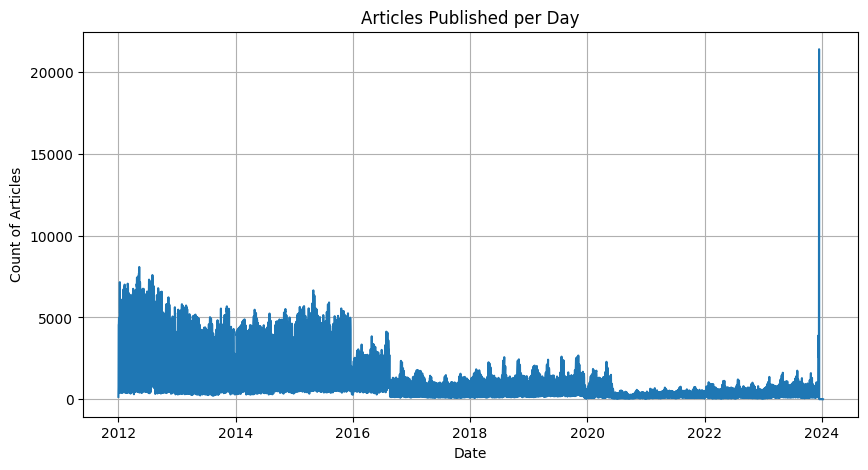

In [9]:
# Converting Date_dt to a daily period
df_filtered_news["Date_dt"] = pd.to_datetime(df_filtered_news["Date_dt"], errors="coerce")

df_filtered_news["date_only"] = df_filtered_news["Date_dt"].dt.date
articles_per_day = df_filtered_news.groupby("date_only")["Article_title"].count().reset_index()

print("Daily articles sample:")
print(articles_per_day.head())

# Plotting daily article counts
plt.figure(figsize=(10, 5))
plt.plot(articles_per_day["date_only"], articles_per_day["Article_title"])
plt.title("Articles Published per Day")
plt.xlabel("Date")
plt.ylabel("Count of Articles")
plt.grid(True)
plt.show()

Article counts by weekday:
      weekday  count_of_articles
1     Monday            1065292
5    Tuesday            1449230
6  Wednesday            1485717
4   Thursday            1506549
0     Friday            1194152
2   Saturday             337346
3     Sunday             172667

Weekday with the MOST articles: Thursday (1506549 articles)


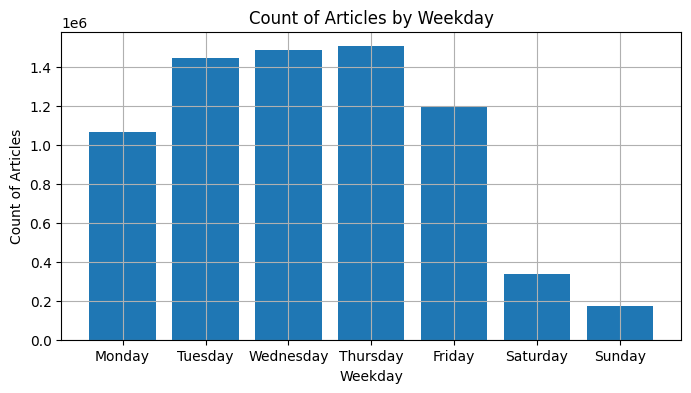

In [28]:
df_filtered_news["Date_dt"] = pd.to_datetime(df_filtered_news["Date_dt"], errors="coerce")

df_filtered_news["weekday"] = df_filtered_news["Date_dt"].dt.day_name()

articles_by_weekday = (
    df_filtered_news
    .groupby("weekday")["Article_title"]
    .count()
    .reset_index(name="count_of_articles")
)

weekday_order = list(calendar.day_name)
articles_by_weekday["weekday"] = pd.Categorical(
    articles_by_weekday["weekday"], 
    categories=weekday_order, 
    ordered=True
)
articles_by_weekday = articles_by_weekday.sort_values("weekday")

print("Article counts by weekday:\n", articles_by_weekday)

max_row = articles_by_weekday.loc[articles_by_weekday["count_of_articles"].idxmax()]
print(f"\nWeekday with the MOST articles: {max_row['weekday']} ({max_row['count_of_articles']} articles)")

plt.figure(figsize=(8, 4))
plt.bar(articles_by_weekday["weekday"], articles_by_weekday["count_of_articles"])
plt.title("Count of Articles by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Count of Articles")
plt.grid(True)
plt.show()

### Top Mentioned Stock Symbols

From millions of articles, we extracted and counted all stock symbols mentioned. Some of the symbols that appear most often are expected such as `AAPL` (Apple Inc), `TSLA` (Tesla), and `GOOG`(Google). However, some of the frequent mentions like `BROGW` (Brooge Energy) and `PMAY` (Innovator US Equity Power Buffer) may indicate unforseen circumstances such as high-frequency PR, naming collisions or spikes in reporting for specific reasons.

Top 20 stock symbols: [('GILD', 11663), ('BABA', 11489), ('NVDA', 11484), ('WFC', 11137), ('INTC', 10854), ('QQQ', 10428), ('BROGW', 10367), ('TSLA', 10294), ('MRK', 9990), ('BPYPO', 9889), ('GOOG', 9867), ('KO', 9670), ('BHFAL', 9521), ('DIS', 9518), ('T', 9309), ('MU', 9300), ('AAPL', 9141), ('AMD', 9126), ('PMAY', 8991), ('CLSN', 8964)]


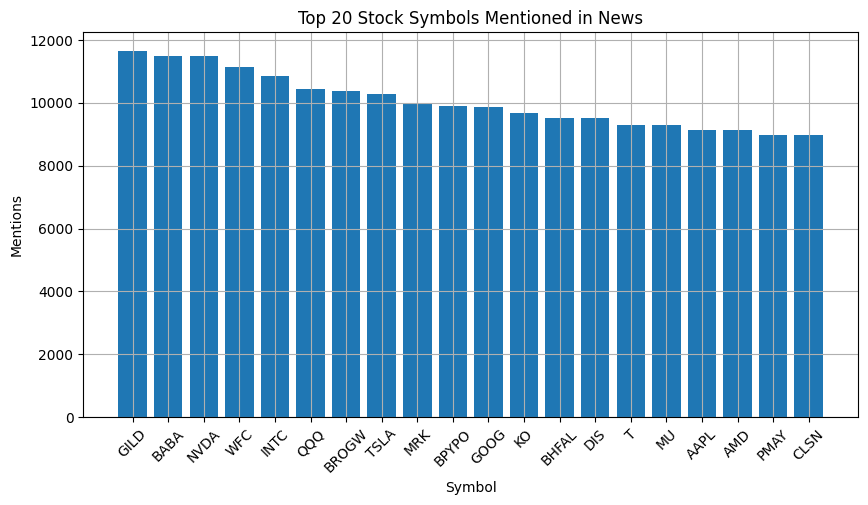

In [10]:
from collections import Counter

symbol_counter = Counter()

for row in df_filtered_news["Stock_symbols"].dropna():
    symbols = [s.strip() for s in row.split(",") if s.strip() != ""]
    symbol_counter.update(symbols)

# Show the top 20
top_symbols = symbol_counter.most_common(20)
print("Top 20 stock symbols:", top_symbols)

# Convert to DataFrame for plotting
symbols_df = pd.DataFrame(top_symbols, columns=["Symbol", "Count"])

plt.figure(figsize=(10, 5))
plt.bar(symbols_df["Symbol"], symbols_df["Count"])
plt.title("Top 20 Stock Symbols Mentioned in News")
plt.xlabel("Symbol")
plt.ylabel("Mentions")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


### Article Title Length Distribution

Most article titles hover around 50–70 characters. The distribution is right-skewed with outliers (max 512 characters). This informs preprocessing choices for future NLP models (e.g., input truncation).

count    7.210953e+06
mean     6.719732e+01
std      2.714175e+01
min      1.000000e+00
25%      5.100000e+01
50%      6.200000e+01
75%      7.700000e+01
max      5.120000e+02
Name: title_length, dtype: float64


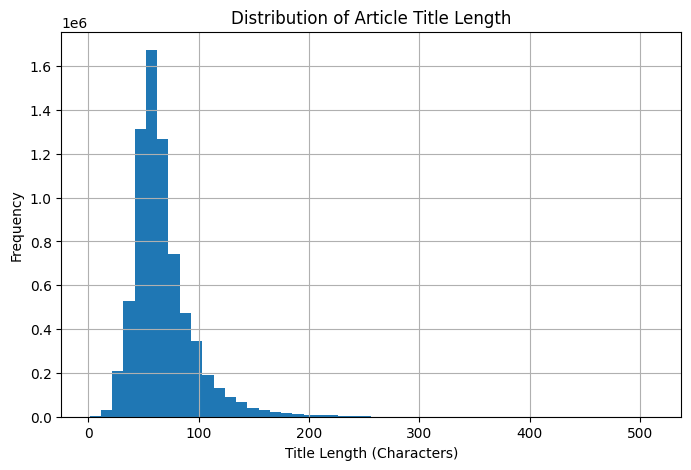

In [11]:
df_filtered_news["title_length"] = df_filtered_news["Article_title"].astype(str).apply(len)

# Basic stats on title length
print(df_filtered_news["title_length"].describe())

plt.figure(figsize=(8, 5))
plt.hist(df_filtered_news["title_length"], bins=50)
plt.title("Distribution of Article Title Length")
plt.xlabel("Title Length (Characters)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## BTC / ETH Dataset Overview

- **BTC**: 1-minute intervals from Jan 2012 to March 2025 (~6.8M rows)
- **ETH**: 1-minute intervals from May 2016 to April 2020 (~2M rows)

Each row includes `Open`, `High`, `Low`, `Close`, `Volume`.

We're particularly interested in minute-level returns, volatility patterns, and weekday behavior.

In [12]:
print("BTC data shape:", btc_df.shape)
print("ETH data shape:", eth_df.shape)
print("Combined crypto data shape:", crypto_df.shape)

btc_df.info()
eth_df.info()

crypto_df.head(5)

BTC data shape: (6779281, 6)
ETH data shape: (1984012, 7)
Combined crypto data shape: (8763293, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6779281 entries, 0 to 6779280
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Date    object 
 1   Open    float64
 2   High    float64
 3   Low     float64
 4   Close   float64
 5   Volume  float64
dtypes: float64(5), object(1)
memory usage: 310.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984012 entries, 0 to 1984011
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Date     object 
 1   Open     float64
 2   High     float64
 3   Low      float64
 4   Close    float64
 5   Volume   float64
 6   Date_dt  object 
dtypes: float64(5), object(2)
memory usage: 106.0+ MB


,Date,Open,High,Low,Close,Volume,Date_dt
0,2012-01-01 10:01:00+00:00,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:01:00+00:00
1,2012-01-01 10:02:00+00:00,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:02:00+00:00
2,2012-01-01 10:03:00+00:00,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:03:00+00:00
3,2012-01-01 10:04:00+00:00,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:04:00+00:00
4,2012-01-01 10:05:00+00:00,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:05:00+00:00


In [13]:
print("BTC Summary:")
print(btc_df.describe())

print("\nETH Summary:")
print(eth_df.describe())


BTC Summary:
               Open          High           Low         Close        Volume
count  6.779281e+06  6.779281e+06  6.779281e+06  6.779281e+06  6.779281e+06
mean   1.507124e+04  1.507766e+04  1.506460e+04  1.507125e+04  5.439022e+00
std    2.068588e+04  2.069364e+04  2.067793e+04  2.068591e+04  2.287430e+01
min    3.800000e+00  3.800000e+00  3.800000e+00  3.800000e+00  0.000000e+00
25%    4.150200e+02  4.151500e+02  4.149700e+02  4.150100e+02  1.846336e-02
50%    6.325550e+03  6.327640e+03  6.323090e+03  6.325570e+03  4.972129e-01
75%    2.370003e+04  2.371100e+04  2.369000e+04  2.370022e+04  3.157064e+00
max    1.089460e+05  1.090300e+05  1.087760e+05  1.089600e+05  5.853852e+03

ETH Summary:
               Open          High           Low         Close        Volume
count  1.984012e+06  1.984012e+06  1.984012e+06  1.984012e+06  1.984012e+06
mean   2.418247e+02  2.419602e+02  2.416817e+02  2.418249e+02  2.612284e+01
std    2.415172e+02  2.417080e+02  2.413119e+02  2.415171e+02

### Understanding Date Range & Missing Values

In [14]:
# BTC date range
btc_df["Date"] = pd.to_datetime(btc_df["Date"], utc=True, errors="coerce")
print("BTC earliest date:", btc_df["Date"].min())
print("BTC latest date:",  btc_df["Date"].max())

# ETH date range
eth_df["Date"] = pd.to_datetime(eth_df["Date"], utc=True, errors="coerce")
print("ETH earliest date:", eth_df["Date"].min())
print("ETH latest date:",  eth_df["Date"].max())

# Check for missing
print("BTC missing values:\n", btc_df.isnull().sum())
print("ETH missing values:\n", eth_df.isnull().sum())

BTC earliest date: 2012-01-01 10:01:00+00:00
BTC latest date: 2025-03-09 00:00:00+00:00
ETH earliest date: 2016-05-09 13:32:00+00:00
ETH latest date: 2020-04-16 00:00:00+00:00
BTC missing values:
 Date      1
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
ETH missing values:
 Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
Date_dt    0
dtype: int64


### Price and Volume Over Time

Visualizing BTC and ETH price histories confirms:
- Bitcoin's long-term upward trend with high volatility.
- Ethereum's volatility profile is slightly more amplified.
- Volume trends spike near price action peaks—especially around late 2017 and late 2020.

These visuals support our use of **volatility technical indicators** in modeling.

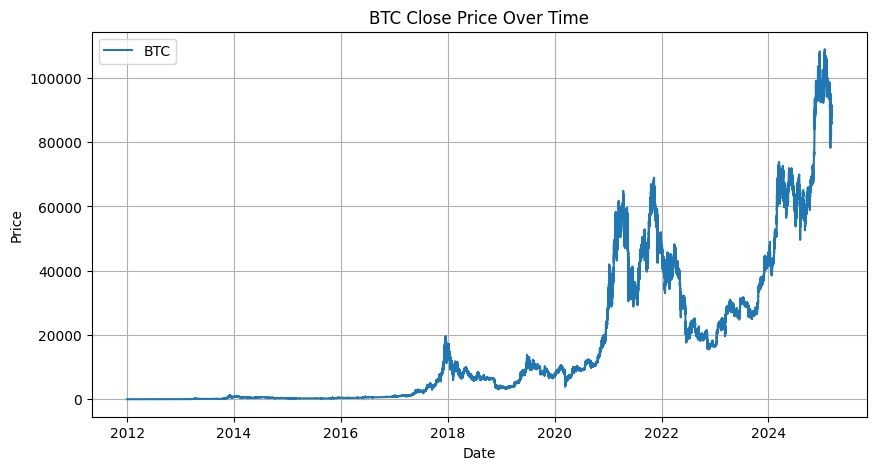

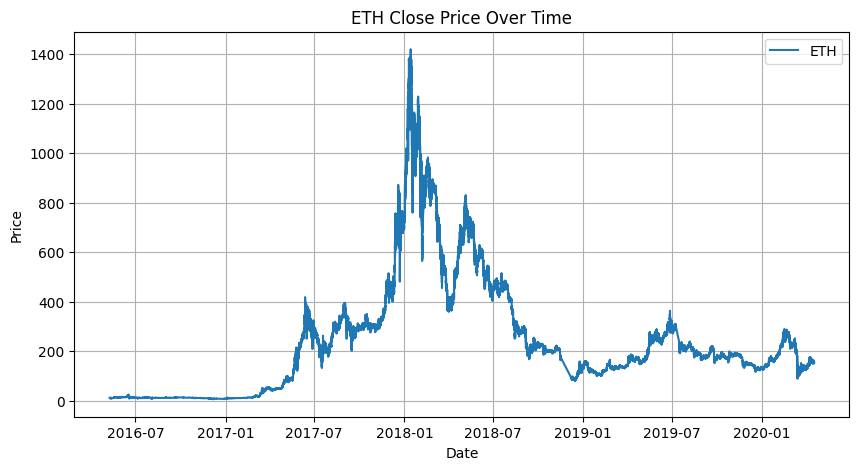

In [15]:
def plot_crypto_data(df, coin_name="Crypto", date_col="Date", price_col="Close"):
    # Convert date col to datetime just in case
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce", utc=True)
    df = df.dropna(subset=[date_col, price_col])
    
    plt.figure(figsize=(10, 5))
    plt.plot(df[date_col], df[price_col], label=coin_name)
    plt.title(f"{coin_name} {price_col} Price Over Time")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_crypto_data(btc_df, coin_name="BTC", price_col="Close")
plot_crypto_data(eth_df, coin_name="ETH", price_col="Close")


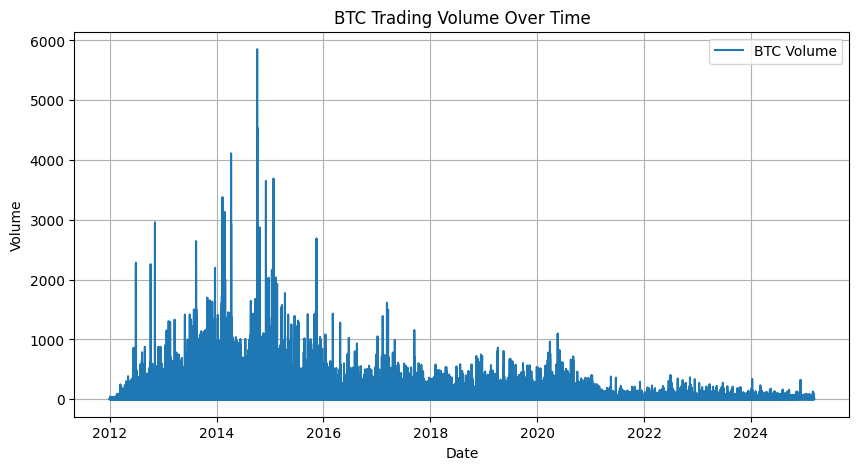

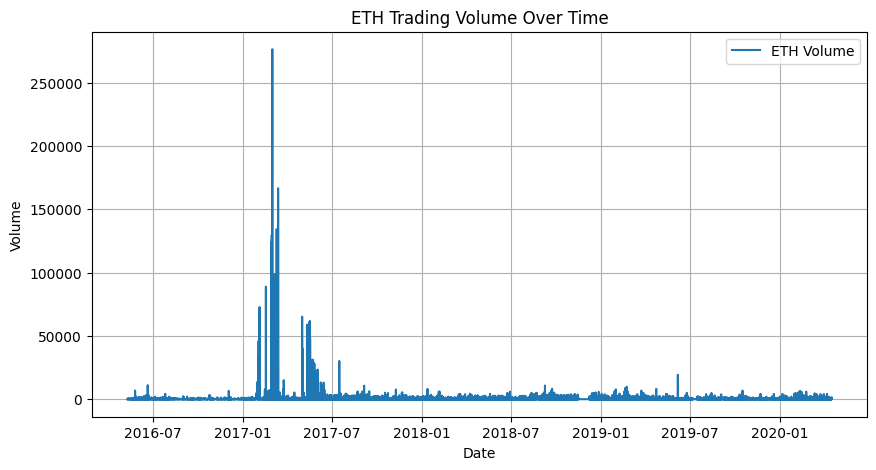

In [16]:
def plot_volume_over_time(df, coin_name="Crypto", date_col="Date", vol_col="Volume"):
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce", utc=True)
    df = df.dropna(subset=[date_col, vol_col])
    
    plt.figure(figsize=(10, 5))
    plt.plot(df[date_col], df[vol_col], label=f"{coin_name} Volume")
    plt.title(f"{coin_name} Trading Volume Over Time")
    plt.xlabel("Date")
    plt.ylabel("Volume")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_volume_over_time(btc_df, coin_name="BTC")
plot_volume_over_time(eth_df, coin_name="ETH")

## Daily Returns Overview

- **BTC** daily returns:
  - Mean: ~0.29%
  - Std: ~4.2%
- **ETH** daily returns:
  - Mean: ~0.38%
  - Std: ~6.1%

ETH is higher-volatility overall. Both coins show heavy tails and occasional extreme events which is expected for crypto coins.

#### Daily Return Distribution

count    4816.000000
mean        0.002924
std         0.041635
min        -0.538385
25%        -0.012227
50%         0.001360
75%         0.018142
max         0.358107
Name: daily_return, dtype: float64
count    1438.000000
mean        0.003873
std         0.061343
min        -0.468599
25%        -0.022472
50%         0.000000
75%         0.025689
max         0.302857
Name: daily_return, dtype: float64


/var/folders/69/x0d9sf3x4tn331kv5900b1h80000gn/T/ipykernel_68720/2482960268.py:17: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  eth_daily["daily_return"] = eth_daily["Close"].pct_change()


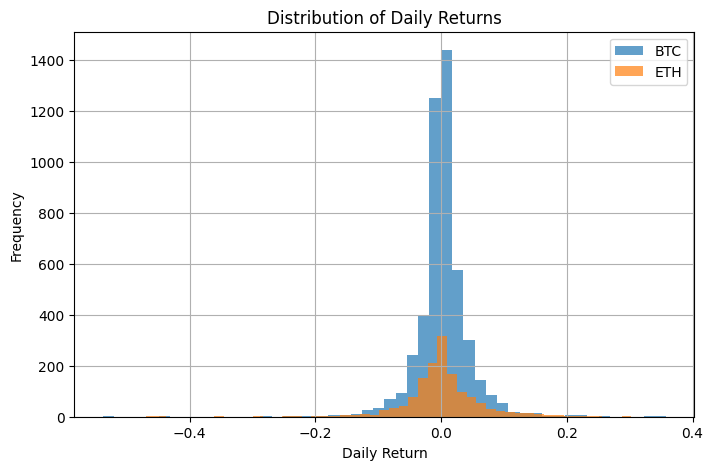

In [17]:
# Overlapping distribution
# Resample to daily close for BTC
btc_df["Date"] = pd.to_datetime(btc_df["Date"], utc=True, errors="coerce")
btc_daily = btc_df.set_index("Date").resample("D").agg({"Open": "first", 
                                                        "High": "max", 
                                                        "Low": "min", 
                                                        "Close": "last", 
                                                        "Volume": "sum"})
btc_daily["daily_return"] = btc_daily["Close"].pct_change()

# Resample to daily close for ETH
eth_df["Date"] = pd.to_datetime(eth_df["Date"], utc=True, errors="coerce")
eth_daily = eth_df.set_index("Date").resample("D").agg({"Open": "first", 
                                                        "High": "max", 
                                                        "Low": "min", 
                                                        "Close": "last", 
                                                        "Volume": "sum"})
eth_daily["daily_return"] = eth_daily["Close"].pct_change()

# Checking stats on daily returns
print(btc_daily["daily_return"].describe())
print(eth_daily["daily_return"].describe())

plt.figure(figsize=(8, 5))
plt.hist(btc_daily["daily_return"].dropna(), bins=50, alpha=0.7, label="BTC")
plt.hist(eth_daily["daily_return"].dropna(), bins=50, alpha=0.7, label="ETH")
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.show()


#### Daily Return Box Plot

/var/folders/69/x0d9sf3x4tn331kv5900b1h80000gn/T/ipykernel_68720/2497639128.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


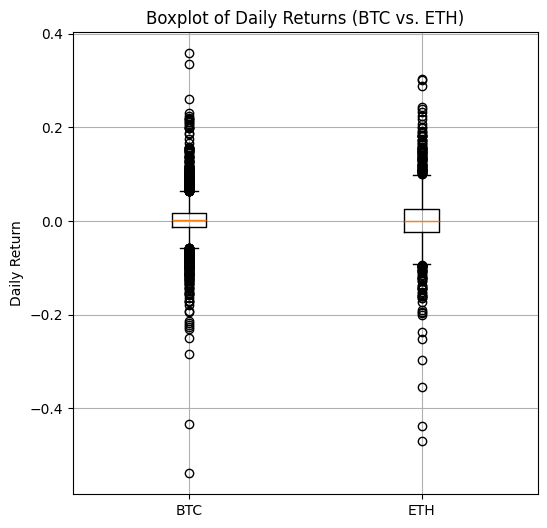

In [20]:
# Side by side boxplots
plt.figure(figsize=(6, 6))
plt.boxplot(
    [
        btc_daily["daily_return"].dropna(), 
        eth_daily["daily_return"].dropna()
    ],
    labels=["BTC", "ETH"]
)
plt.title("Boxplot of Daily Returns (BTC vs. ETH)")
plt.ylabel("Daily Return")
plt.grid(True)
plt.show()

#### Daily Return Time Series

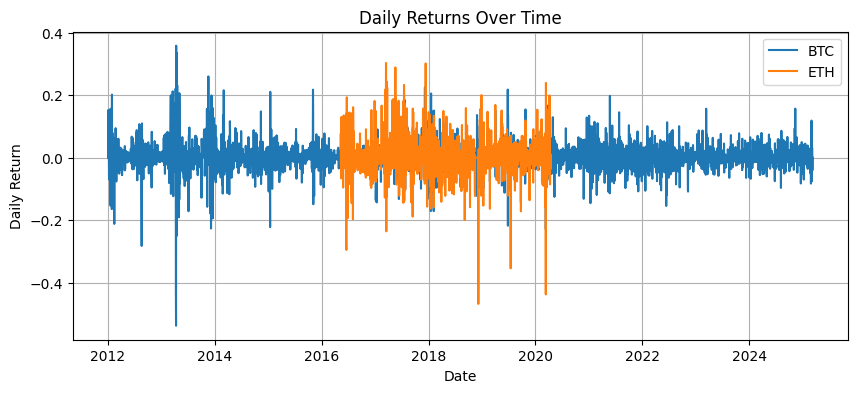

In [21]:
# Time series to understand volitility
plt.figure(figsize=(10, 4))
plt.plot(btc_daily.index, btc_daily["daily_return"], label="BTC")
plt.plot(eth_daily.index, eth_daily["daily_return"], label="ETH")
plt.title("Daily Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.grid(True)
plt.show()

### Weekday Return Patterns

Interesting results emerge:

- **BTC** sees highest average returns on **Mondays and Tuesdays**
- **ETH** peaks on **Tuesdays**, with Friday and Sunday also notable

Volatility tends to spike mid-week and drop on weekends, likely due to global market overlaps and media cycles. Additionally, traditional traders who are familiar with typical weekend market closures may be less active on the weekends and more active mid week. This supports the additional and relaiance on temporal features in our future models.

In [22]:
btc_daily_reset = btc_daily.reset_index()
btc_daily_reset["weekday"] = btc_daily_reset["Date"].dt.day_name()  


eth_daily_reset = eth_daily.reset_index()
eth_daily_reset["weekday"] = eth_daily_reset["Date"].dt.day_name()

In [23]:
btc_weekday_stats = btc_daily_reset.groupby("weekday")["daily_return"].agg(
    mean_return=("mean"),
    median_return=("median"),
    count=("size"),
    max_return=("max"),
    min_return=("min"),
    std_dev=("std")
).reset_index()

eth_weekday_stats = eth_daily_reset.groupby("weekday")["daily_return"].agg(
    mean_return=("mean"),
    median_return=("median"),
    count=("size"),
    max_return=("max"),
    min_return=("min"),
    std_dev=("std")
).reset_index()

print("BTC weekday stats:\n", btc_weekday_stats)
print("\nETH weekday stats:\n", eth_weekday_stats)

BTC weekday stats:
      weekday  mean_return  median_return  count  max_return  min_return  \
0     Friday     0.001504       0.001159    688    0.358107   -0.226969   
1     Monday     0.006252       0.002947    688    0.259831   -0.171537   
2   Saturday     0.002117       0.001089    688    0.206092   -0.164966   
3     Sunday     0.000094       0.000383    689    0.201629   -0.282845   
4   Thursday     0.001485       0.000210    688    0.225064   -0.538385   
5    Tuesday     0.004860       0.002325    688    0.217376   -0.250575   
6  Wednesday     0.004159       0.002336    688    0.334816   -0.433551   

    std_dev  
0  0.041623  
1  0.042771  
2  0.032313  
3  0.034428  
4  0.048912  
5  0.041014  
6  0.047483  

ETH weekday stats:
      weekday  mean_return  median_return  count  max_return  min_return  \
0     Friday     0.005412       0.002145    205    0.288481   -0.468599   
1     Monday     0.006085       0.000000    206    0.232527   -0.159326   
2   Saturday     0.00

In [ ]:
weekday_order = list(calendar.day_name)  # ["Monday", "Tuesday", ..., "Sunday"]

btc_weekday_stats["weekday"] = pd.Categorical(
    btc_weekday_stats["weekday"],
    categories=weekday_order,
    ordered=True
)
btc_weekday_stats = btc_weekday_stats.sort_values("weekday")

In [25]:
print("BTC highest average daily return on:\n",
      btc_weekday_stats.loc[btc_weekday_stats["mean_return"].idxmax()])

print("\nETH highest average daily return on:\n",
      eth_weekday_stats.loc[eth_weekday_stats["mean_return"].idxmax()])

BTC highest average daily return on:
 weekday            Monday
mean_return      0.006252
median_return    0.002947
count                 688
max_return       0.259831
min_return      -0.171537
std_dev          0.042771
Name: 1, dtype: object

ETH highest average daily return on:
 weekday           Tuesday
mean_return      0.006649
median_return   -0.000303
count                 206
max_return       0.301401
min_return      -0.354649
std_dev          0.069647
Name: 5, dtype: object


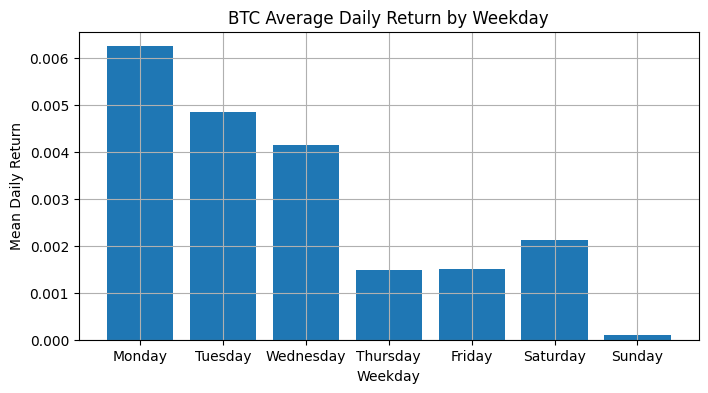

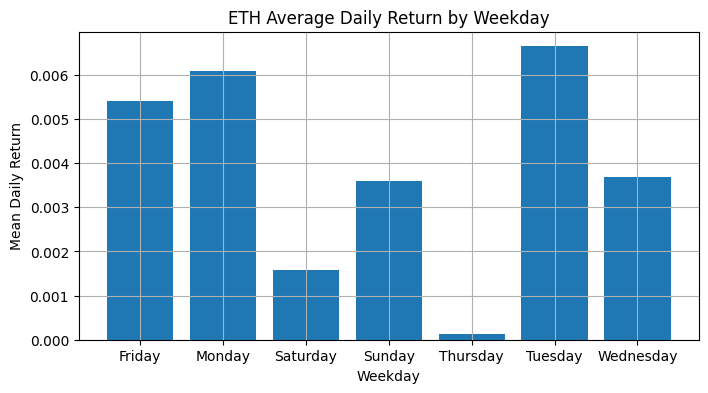

In [26]:
# BTC
plt.figure(figsize=(8, 4))
plt.bar(btc_weekday_stats["weekday"], btc_weekday_stats["mean_return"])
plt.title("BTC Average Daily Return by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Mean Daily Return")
plt.grid(True)
plt.show()

# ETH
plt.figure(figsize=(8, 4))
plt.bar(eth_weekday_stats["weekday"], eth_weekday_stats["mean_return"])
plt.title("ETH Average Daily Return by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Mean Daily Return")
plt.grid(True)
plt.show()

## BTC vs. ETH Return Correlation

- **Daily** correlation: ~0.47 (moderate)
- **Minute-level** correlation: ~0.00

These metrics indicate high-level trends are moderately aligned (0.47), but minute-by-minute price moves are mostly independent (0.0). It justifies training separate models or having fusion layers that handle BTC and ETH independently.

In [18]:
# Join daily returns for BTC and ETH on the date index
merged_daily = pd.DataFrame({
    "BTC_return": btc_daily["daily_return"],
    "ETH_return": eth_daily["daily_return"]
}).dropna()

# Daily return correlation
correlation = merged_daily.corr()
print("Correlation between BTC and ETH daily returns:\n", correlation)

Correlation between BTC and ETH daily returns:
             BTC_return  ETH_return
BTC_return     1.00000     0.46913
ETH_return     0.46913     1.00000


In [ ]:
# Minute return correlation
btc_df["Date"] = pd.to_datetime(btc_df["Date"], errors="coerce", utc=True)
eth_df["Date"] = pd.to_datetime(eth_df["Date"], errors="coerce", utc=True)

btc_df = btc_df.sort_values("Date").set_index("Date")
eth_df = eth_df.sort_values("Date").set_index("Date")

btc_df["minute_return"] = btc_df["Close"].pct_change()
eth_df["minute_return"] = eth_df["Close"].pct_change()

merged_minute = pd.merge(
    btc_df[["minute_return"]],
    eth_df[["minute_return"]],
    left_index=True,
    right_index=True,
    suffixes=("_BTC", "_ETH")
).dropna()

correlation_minute = merged_minute.corr()
print("Correlation between BTC and ETH minute-level returns:\n", correlation_minute)

Correlation between BTC and ETH minute-level returns:
                    minute_return_BTC  minute_return_ETH
minute_return_BTC           1.000000           0.000242
minute_return_ETH           0.000242           1.000000


## Intraday Volatility by Hour (UTC)

Both coins exhibit:
- Quietest hours: 2–5 AM UTC
- Midday dip (7–10 AM UTC)
- Peaks: 18–22 UTC

This suggests global market overlap boosts volatility. Including **hour-of-day features** could increase model precision for short-term predictions.

## Volatility by Hour & Weekday

Returns show stronger spikes on **Mondays**, likely due to weekend news. Sunday night also picks up in volatility, aligning with market reopenings for traditional stocks on Monday. 

This pattern held for both BTC and ETH, reinforcing the importance of **calendar effects** in crypto models.

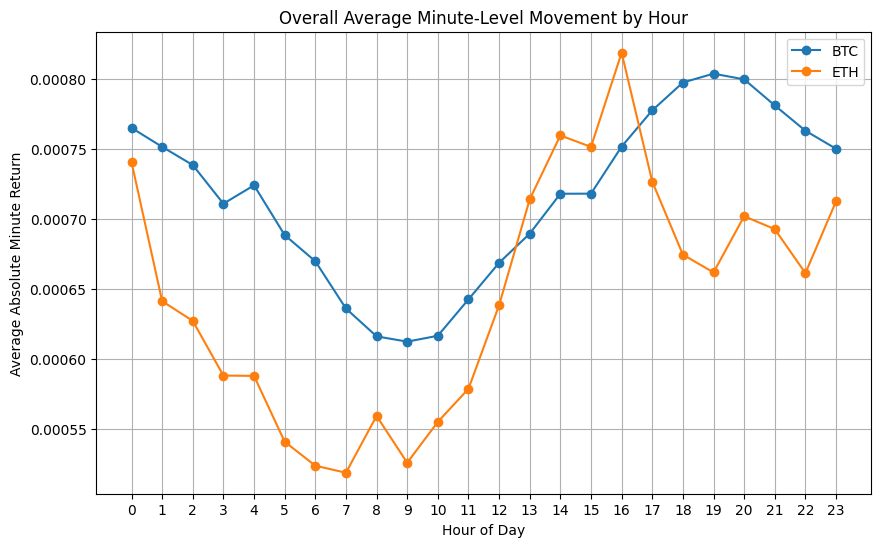

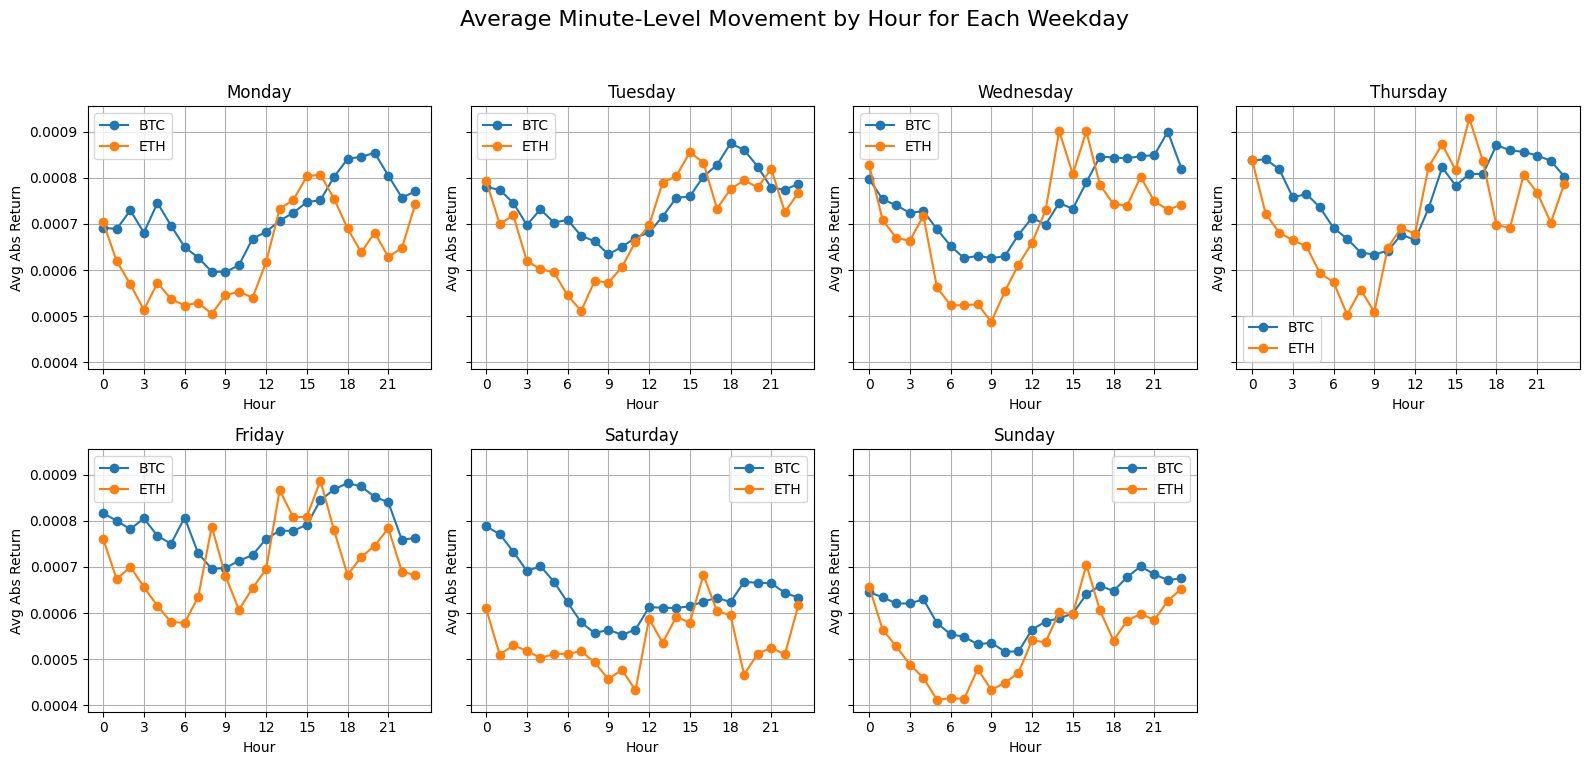

In [34]:
def prepare_df(df):
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce", utc=True)
        df = df.sort_values("Date").set_index("Date")
    else:
        df.index = pd.to_datetime(df.index, errors="coerce", utc=True)
        df = df.sort_index()
    return df

def calculate_minute_returns(df):
    df["minute_return"] = df["Close"].pct_change()
    df["abs_minute_return"] = df["minute_return"].abs()
    return df

def analyze_overall_hourly_movement(btc_df, eth_df):
    btc_df = prepare_df(btc_df)
    eth_df = prepare_df(eth_df)
    btc_df = calculate_minute_returns(btc_df)
    eth_df = calculate_minute_returns(eth_df)
    btc_df["hour"] = btc_df.index.hour
    eth_df["hour"] = eth_df.index.hour
    btc_hourly = btc_df.groupby("hour")["abs_minute_return"].mean().reset_index(name="btc_avg_movement")
    eth_hourly = eth_df.groupby("hour")["abs_minute_return"].mean().reset_index(name="eth_avg_movement")
    overall = pd.merge(btc_hourly, eth_hourly, on="hour")
    plt.figure(figsize=(10, 6))
    plt.plot(overall["hour"], overall["btc_avg_movement"], marker="o", label="BTC")
    plt.plot(overall["hour"], overall["eth_avg_movement"], marker="o", label="ETH")
    plt.title("Overall Average Minute-Level Movement by Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("Average Absolute Minute Return")
    plt.xticks(range(0, 24))
    plt.grid(True)
    plt.legend()
    plt.show()
    return overall

def analyze_hourly_movement_by_weekday(btc_df, eth_df):
    btc_df = prepare_df(btc_df)
    eth_df = prepare_df(eth_df)
    btc_df = calculate_minute_returns(btc_df)
    eth_df = calculate_minute_returns(eth_df)
    btc_df["hour"] = btc_df.index.hour
    eth_df["hour"] = eth_df.index.hour
    btc_df["weekday"] = btc_df.index.day_name()
    eth_df["weekday"] = eth_df.index.day_name()
    weekdays = list(calendar.day_name)
    fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=True)
    axes = axes.flatten()
    for i, day in enumerate(weekdays):
        btc_day = btc_df[btc_df["weekday"] == day]
        eth_day = eth_df[eth_df["weekday"] == day]
        btc_hourly = btc_day.groupby("hour")["abs_minute_return"].mean().reset_index(name="btc_avg_movement")
        eth_hourly = eth_day.groupby("hour")["abs_minute_return"].mean().reset_index(name="eth_avg_movement")
        ax = axes[i]
        ax.plot(btc_hourly["hour"], btc_hourly["btc_avg_movement"], marker="o", label="BTC")
        ax.plot(eth_hourly["hour"], eth_hourly["eth_avg_movement"], marker="o", label="ETH")
        ax.set_title(day)
        ax.set_xlabel("Hour")
        ax.set_ylabel("Avg Abs Return")
        ax.set_xticks(range(0, 24, 3))
        ax.grid(True)
        ax.legend()
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    fig.suptitle("Average Minute-Level Movement by Hour for Each Weekday", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

overall = analyze_overall_hourly_movement(btc_df.copy(), eth_df.copy())
analyze_hourly_movement_by_weekday(btc_df.copy(), eth_df.copy())

## Key Takeaways

- News article volume typically increases mid-week, and titles are often short.
- BTC and ETH exhibit high volatility and weekday-specific patterns.
- BTC/ETH returns are only moderately correlated over daily intervals—but diverge at minute scale.
- Intraday volatility spikes in late UTC hours.
- Monday and Tuesday consistently produce higher average returns.

These insights shape our feature engineering and confirm that BTC and ETH deserve distinct treatment within the ensemble model.